# Introduction

This notebook gives a simple implementation of the noisy channel model for non-word spelling correction. It also includes the demonstration of the Zipf law. 


In [6]:
# Boring preliminaries
%pylab inline
import re
import math
import string
from collections import Counter
from __future__ import division

# %pylab inline causes numpy.sum() overriding builtin's sum(). 
import builtins as base

Populating the interactive namespace from numpy and matplotlib


## (1) Data: Text and Words


Before we can do things with words, we need some words.  First we need some *text*, possibly from a *file*.  Then we can break the text into words.  I happen to have a big text called `big.txt`.  We can read it, and see how big it is (in characters):

In [7]:
# save space
import gzip
with gzip.open('./asset/big.txt.gz', 'rt') as f:
    TEXT = f.read()

len(TEXT)

6488666

So, six million characters.

Now let's break the text up into words (or more formal-sounding, *tokens*).  For now we'll ignore all the punctuation and numbers, and anything that is not a letter.

In [8]:
def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower()) 

In [9]:
tokens('This is: A test, 1, 2, 3, this is.')

['this', 'is', 'a', 'test', 'this', 'is']

In [10]:
WORDS = tokens(TEXT)
len(WORDS)

1105285

So, a million words.  Here are the first 10:



In [11]:
print(WORDS[:10])

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes']


## (2) The Bag-of-Words Model


The list `WORDS` is a list of the words in the `TEXT`, but it can also serve as a *generative model* of text. We know that language is very complicated, but we can create a simplified model of language that captures part of the complexity.  In the *bag of words* model, we ignore the order of words, but maintain their frequency.  Think of it this way: take all the words from the text, and throw them into a bag.  Shake the bag, and then generating a sentence consists of pulling words out of the bag one at a time.  Chances are it won't be grammatical or sensible, but it will have words in roughly the right proportions.  Here's a function to sample an *n* word sentence from a bag of words:

In [12]:
def sample(bag, n=10):
    "Sample a random n-word sentence from the model described by the bag of words."
    return ' '.join(random.choice(bag) for _ in range(n))

In [13]:
sample(WORDS)

'of listed meeting painlessly condition two virtue though quite prince'

Another representation for a bag of words is a `Counter`, which is a dictionary of `{'word': count}` pairs.  For example,

In [14]:
Counter(tokens('Is this a test? It is a test!'))

Counter({'a': 2, 'is': 2, 'it': 1, 'test': 2, 'this': 1})

A `Counter` is like a `dict`, but with a few extra methods.  Let's make a `Counter` for the big list of `WORDS` and get a feel for what's there:

In [15]:
COUNTS = Counter(WORDS)

print(COUNTS.most_common(10))

[('the', 80030), ('of', 40025), ('and', 38313), ('to', 28766), ('in', 22050), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681)]


In [16]:
for w in tokens('the rare and neverbeforeseen words'):
    print(COUNTS[w], w)

80030 the
83 rare
38313 and
0 neverbeforeseen
460 words


In 1935, linguist George Zipf noted that in any big text, the *n*th most frequent word appears with a frequency of about 1/*n* of the most frequent word. He get's credit for *Zipf's Law*, even though Felix Auerbach made the same observation in 1913.  If we plot the frequency of words, most common first, on a log-log plot, they should come out as a straight line if Zipf's Law holds.  Here we see that it is a fairly close fit:

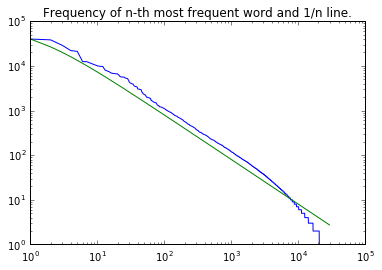

In [17]:
M = COUNTS['the']
yscale('log'); xscale('log'); title('Frequency of n-th most frequent word and 1/n line.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS)+1)]);

In [18]:
cands = ['actress', 'cress', 'caress', 'access', 'across', 'acres']
pairs = [(w, COUNTS[w]) for w in cands]
for pair in pairs:
    print('{}: {}'.format(pair[0], pair[1]))

actress: 7
cress: 0
caress: 3
access: 56
across: 222
acres: 36


In [19]:
print('across / access in the bigw corpus =', 222.0 / 56)
print('across / access in the COCA corpus =', 120844.0 / 37038)

across / access in the bigw corpus = 3.9642857142857144
across / access in the COCA corpus = 3.2627031697175872


Converting the absolute count to a probability number is easy. 

In [20]:
base.sum(COUNTS.values())


1105285

In [21]:
def pdist(counter):
    "Make a probability distribution, given evidence from a Counter."
    N = int(base.sum(counter.values()))
    return lambda x: counter[x]/N

P = pdist(COUNTS)

In [27]:
for w in cands:
    print('P({}) \t= {:8.6e}'.format(w, P(w)))

P(actress) 	= 6.333208e-06
P(cress) 	= 0.000000e+00
P(caress) 	= 2.714232e-06
P(access) 	= 5.066567e-05
P(across) 	= 2.008532e-04
P(acres) 	= 3.257078e-05


(3) Task: Spelling Correction
========

Given a word *w*, find the most likely correction *c* = `correct(`*w*`)`. We solve this problem in two steps:
1. Find a set of *candidates*. 
2. Score each word in the candidates based on the noisy channel model. 

In the noisy channel model, we model
$$
P(c|w) \propto P(w|c) \cdot P(c)
$$

For $P(c)$, known as the *prior*, we will just use `P(c)`. For $P(w|c)$, known as the *likelihood*, we score it using some heuristic function based on the *edit distance* between $w$ and $c$. Also we limit the set of candidates to those whose edit distance to $w$ is no more than 2. 


        


In [38]:
def known(words):
    "Return the subset of words that are actually in the dictionary."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits2(word):
    "Return all strings that are two edits away from this word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

The functions `known` and `edits0` are easy; and `edits2` is easy if we assume we have `edits1`:

Now for `edits1(word)`: the set of candidate words that are one edit away. For example, given `"wird"`, this would include `"weird"` (inserting an `e`) and `"word"` (replacing a `i` with a `o`), and also `"iwrd"` (transposing `w` and `i`; then `known` can be used to filter this out of the set of final candidates). How could we get them?  One way is to *split* the original word in all possible places, each split forming a *pair* of words, `(a, b)`, before and after the place, and at each place, either delete, transpose, replace, or insert a letter:

<table>
  <tr><td> pairs: <td><tt> Ø+wird <td><tt> w+ird <td><tt> wi+rd <td><tt>wir+d<td><tt>wird+Ø<td><i>Notes:</i><tt> (<i>a</i>, <i>b</i>)</tt> pair</i>
  <tr><td> deletions: <td><tt>Ø+ird<td><tt> w+rd<td><tt> wi+d<td><tt> wir+Ø<td><td><i>Delete first char of b</i>
  <tr><td> transpositions: <td><tt>Ø+iwrd<td><tt> w+rid<td><tt> wi+dr</tt><td><td><td><i>Swap first two chars of b
  <tr><td> replacements: <td><tt>Ø+?ird<td><tt> w+?rd<td><tt> wi+?d<td><tt> wir+?</tt><td><td><i>Replace char at start of b
  <tr><td> insertions: <td><tt>Ø+?+wird<td><tt> w+?+ird<td><tt> wi+?+rd<td><tt> wir+?+d<td><tt> wird+?+Ø</tt><td><i>Insert char between a and b
</table>

In [39]:
def edits1(word):
    "Return all strings that are one edit away from this word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [40]:
splits('wird')

[('', 'wird'), ('w', 'ird'), ('wi', 'rd'), ('wir', 'd'), ('wird', '')]

In [41]:
print(edits0('wird'))

{'wird'}


In [42]:
print(edits1('wird'))

{'witrd', 'wirad', 'wirds', 'wsrd', 'iwird', 'fwird', 'wdird', 'twird', 'ward', 'zird', 'wurd', 'jwird', 'wirnd', 'wirdv', 'sird', 'wirdb', 'wirdg', 'wicrd', 'wirud', 'wivrd', 'wirde', 'wixd', 'wild', 'wwird', 'wihd', 'wqrd', 'wimd', 'wirg', 'wtird', 'wircd', 'wiard', 'kwird', 'qird', 'widrd', 'wivd', 'pwird', 'wmrd', 'xird', 'wiqd', 'weird', 'wirdw', 'wiird', 'wirdu', 'wiry', 'wiud', 'wyird', 'mird', 'wirfd', 'wirxd', 'wizd', 'gird', 'wiprd', 'wirk', 'wirda', 'gwird', 'wirtd', 'fird', 'bwird', 'wsird', 'wired', 'wzird', 'hwird', 'wid', 'wiod', 'wijrd', 'wirpd', 'oird', 'wlird', 'wirw', 'wirdi', 'qwird', 'wirzd', 'wpird', 'wfrd', 'wirt', 'wxrd', 'eird', 'vird', 'wvrd', 'wzrd', 'kird', 'uird', 'wierd', 'wiryd', 'wirdl', 'rird', 'whird', 'wirdj', 'wiri', 'wirc', 'uwird', 'wirdy', 'yird', 'wiwd', 'wirdt', 'bird', 'wiyrd', 'owird', 'wirdd', 'widr', 'wqird', 'wrid', 'wicd', 'wirv', 'wihrd', 'wirf', 'wiurd', 'wirhd', 'wirs', 'hird', 'wirbd', 'wiwrd', 'jird', 'wxird', 'wirld', 'wirqd', 'wirdk

In [43]:
print(len(edits2('wird')))

24254


Now we implement `correct`.

In [44]:
from math import exp

BETA = 1.0

def score(err, beta = BETA):
    return exp(-beta * err)

In [45]:
for b in [0.5, 1.0, 1.5, 2.0]:
    print('beta = {}\tscore(1) = {}\tscore(2) = {}'.format(b, score(1, b), score(2, b)))

beta = 0.5	score(1) = 0.6065306597126334	score(2) = 0.36787944117144233
beta = 1.0	score(1) = 0.36787944117144233	score(2) = 0.1353352832366127
beta = 1.5	score(1) = 0.22313016014842982	score(2) = 0.049787068367863944
beta = 2.0	score(1) = 0.1353352832366127	score(2) = 0.01831563888873418


In [57]:
DEBUG = True
def correct(word):
    "Find the best spelling correction for this word."
    if known([word]):
        print('Error: this function only works with words not in the dictionary.')
        return word
    
    # get the candidates that are <=2 distance away from word
    candidates = [(w, 1) for w in known(edits1(word))]
    candidates.extend([(w, 2) for w in known(edits2(word))])
    if len(candidates) == 0:
        print('Warning: no candidate found for {}. I do not know how to correct it.'.format(word))
        return word
    # general case
    
    best_cand = None
    best_prob = -1.0
    for cand, err in candidates:
        prob = P(cand) * score(err)
        # debug
        if DEBUG:
            print('.. c = {} (err = {}) => Prob = {} <= prior = {}, likelihood = {}'.format(
                    cand, err, prob, P(cand), score(err)))
        
        if prob > best_prob: 
            best_cand = cand 
            best_prob = prob
    
    return best_cand

In [59]:
correct('wirxdy')

.. c = wordy (err = 2) => Prob = 1.2244378892015426e-07 <= prior = 9.047440252966429e-07, likelihood = 0.1353352832366127
.. c = windy (err = 2) => Prob = 2.4488757784030853e-07 <= prior = 1.8094880505932859e-06, likelihood = 0.1353352832366127
.. c = wired (err = 2) => Prob = 4.897751556806171e-07 <= prior = 3.6189761011865717e-06, likelihood = 0.1353352832366127
.. c = wiry (err = 2) => Prob = 1.2244378892015426e-07 <= prior = 9.047440252966429e-07, likelihood = 0.1353352832366127


'wired'

## Points to Ponder

Consider the following questions: 

* Consider two candidates with the same edit distance. Which candidate will be selected by the model? 
* What's the **essential** role of `score(err)` function in this model? (Hint: what's the effect if I can the base from $e$ to some other constant?)
* In the textbook/slides, a more detailed error model (named $M_1$) is used. Understand the advantage of $M_1$ against the simple error model (named $M_0$) used in this implementation. How many parameters are there for $M_1$ assuming the alphabet size is $|\Sigma|$? 
* Can you think of another error model considering the fact that the prefix and suffix of a word is less likely to have spelling errors? 


Some more tests.

In [62]:
correct('gog')

.. c = bog (err = 1) => Prob = 6.656734528586606e-07 <= prior = 1.8094880505932859e-06, likelihood = 0.36787944117144233
.. c = gong (err = 1) => Prob = 3.328367264293303e-07 <= prior = 9.047440252966429e-07, likelihood = 0.36787944117144233
.. c = fog (err = 1) => Prob = 7.655244707874597e-06 <= prior = 2.0809112581822788e-05, likelihood = 0.36787944117144233
.. c = agog (err = 1) => Prob = 3.328367264293303e-07 <= prior = 9.047440252966429e-07, likelihood = 0.36787944117144233
.. c = ogg (err = 1) => Prob = 6.9895712550159365e-06 <= prior = 1.8999624531229502e-05, likelihood = 0.36787944117144233
.. c = gag (err = 1) => Prob = 6.656734528586606e-07 <= prior = 1.8094880505932859e-06, likelihood = 0.36787944117144233
.. c = god (err = 1) => Prob = 0.00012081973169384689 <= prior = 0.0003284220811826814, likelihood = 0.36787944117144233
.. c = dog (err = 1) => Prob = 2.1301550491477138e-05 <= prior = 5.790361761898515e-05, likelihood = 0.36787944117144233
.. c = log (err = 1) => Prob = 

'of'

Correcting "gog" to "of" is probably not correct. Can we change the base of the $M_0$ to prevent it from doing so? Can you think of a way to find the constant given a set of "training examples"? 

### Utilities

In [86]:
rare_words = []
for k in COUNTS:
    if COUNTS[k] == 1:
        rare_words.append(k)
print(sorted(rare_words))

['aah', 'abacus', 'abasement', 'abbot', 'abbots', 'abbreviations', 'abc', 'abdicate', 'abdicated', 'abductors', 'abel', 'abeyance', 'abhor', 'abhorrence', 'abhorrent', 'abilities', 'abject', 'abjure', 'ablest', 'ably', 'aboard', 'abodes', 'abominably', 'abomination', 'abort', 'abortive', 'abounding', 'aboveboard', 'abramovna', 'abridge', 'abrogated', 'absentee', 'absentees', 'absentmindedly', 'absolutism', 'abstention', 'abstiens', 'abstruse', 'ac', 'acacia', 'academies', 'acadia', 'acceded', 'acceding', 'accidently', 'accommodated', 'accommodations', 'accompli', 'accoucheur', 'accountable', 'accounting', 'accouterments', 'accredited', 'accursed', 'accuser', 'accusers', 'accusing', 'ace', 'acetabular', 'acetatis', 'acetones', 'achtung', 'acids', 'acknowledges', 'acquaint', 'acquiesced', 'acquiescence', 'acquirement', 'acquires', 'acquittal', 'acreage', 'activate', 'activist', 'acuteness', 'ad', 'adair', 'adamses', 'adaptation', 'adaptations', 'addison', 'adducing', 'adduct', 'adelaide'

## Further reading:

* http://norvig.com/spell-correct.html
* http://nbviewer.jupyter.org/url/norvig.com/ipython/How%20to%20Do%20Things%20with%20Words.ipynb. This is a notebook (python 2 though) for the book chapter: http://norvig.com/ngrams/ch14.pdf
* http://www.python-course.eu/python3_memoization.php for an introduction  the `@memo` decorator. 


## Exercise

1. The current implementation of the `correct()` function does not takes the context into consideration. Can you implement a version where the prior is based on the bigram language model? I.e., $P(w_{i+1} \mid w_i) = P(w_{i} w_{i+1}) / P(w_i)$. 

